# Fast Fourier Transform Forecasting Model (FFT)
The following is a brief demonstration of the FFT forecasting model. This model is especially suited for data that is very seasonal. The datasets chosen for this demonstration were selected accordingly.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

import pandas as pd

from darts.datasets import AirPassengersDataset, EnergyDataset, TemperatureDataset
from darts.metrics import mae
from darts.models import FFT, ExponentialSmoothing, Theta
from darts.utils.missing_values import fill_missing_values

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


## Read and format
Here we simply read the CSV file containing daily temperatures, and transform the values into the desired format.

In [3]:
ts = TemperatureDataset().load()

## Constructing `TimeSeries` instances for training and validation

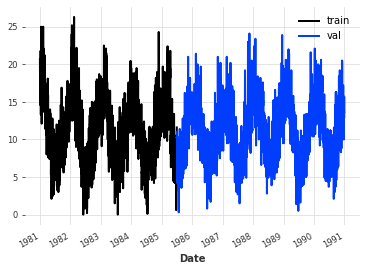

In [4]:
train, val = ts.split_after(pd.Timestamp("19850701"))
train.plot(label="train")
val.plot(label="val")

## Basic FFT model

In [5]:
model = FFT(required_matches=set(), nr_freqs_to_keep=None)
model.fit(train)
pred_val = model.predict(len(val))

The plot below shows us that a simple DFT with a random train-test split will most likely lead to bad results. Upon closer inspection we can see that the prediction (in purple) simply repeats the training set (blue). This is the standard behavior of the DFT, and by itself it is quite useless, since repeating our training set could be done much more efficiently. Three improvements were made to this approach.

MAE: 5.424526892430279


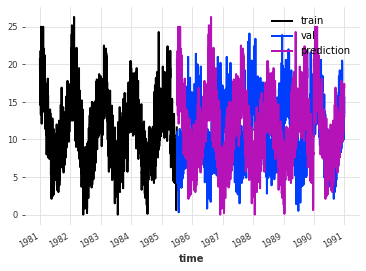

In [6]:
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")
print("MAE:", mae(pred_val, val))

## Improvement 1: Crop the training set
The first improvement consists of cropping the training set before feeding it to the FFT algorithm such that the first timestamp in the cropped series matches the first timestamp to be predicted in terms of seasonality, i.e. it has the same month, day, weekday, time of day, etc. We could achieve this by passing the optional argument `required_matches` to the FFT constructor that explicitly tells our model which timestamp attributes are relevant. But actually, if we don't set it manually, the model will attempt to automatically find the pd.Timestamp attributes that are relevant and crop the training set accordingly (which we will do here).

In [7]:
model = FFT(nr_freqs_to_keep=None)
model.fit(train)
pred_val = model.predict(len(val))

We can see that the results look like the seasonality of the predictions nicely aligns with the seasonality of the validation set. However, we are still just repeating the training set, including all of the noise. Looking at the error we can see that this is still a pretty bad forecast.

MAE: 3.0995766932270916


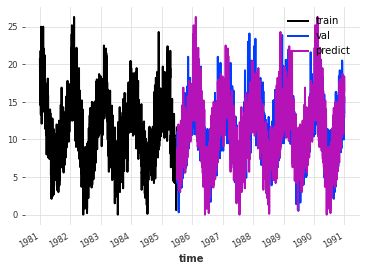

In [8]:
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="predict")
print("MAE:", mae(pred_val, val))

## Improvement 2: Filtering out low-amplitude waves
The decomposition of the DFT into the frequency domain allows us to selectively filter out waves with low amplitudes. This allows us to keep strong seasonal trends while discarding some noise. This is achieved in the FFT model by passing the optional argument `nr_freqs_to_keep`. This argument represents the total number of frequencies that will be kept. For instance, if a value of 20 is passed, only the 20 frequencies with the highest amplitudes will be utilized. The default value is set to 10.

In [9]:
model = FFT(nr_freqs_to_keep=20)
model.fit(train)
pred_val = model.predict(len(val))

We get a signal that is less noisy. Depending on the data set, this might be a better forecast. Looking at the error metric, we can see that this model performs significantly better than the previous models.

MAE: 2.2941917142812893


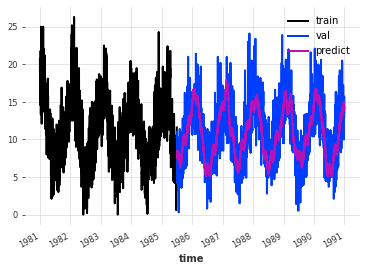

In [10]:
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="predict")
print("MAE:", mae(pred_val, val))

## Improvement 3: Detrending
Let's try out a different data set that has a global upward trend

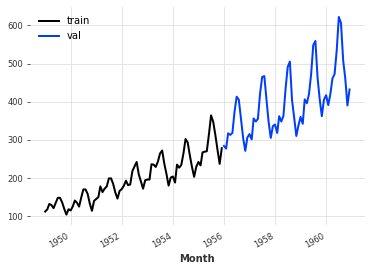

In [11]:
ts_2 = AirPassengersDataset().load()
train, val = ts_2.split_after(pd.Timestamp("19551201"))
train.plot(label="train")
val.plot(label="val")

In [12]:
model = FFT()
model.fit(train)
pred_val = model.predict(len(val))

Clearly, our model fails completely at incorporating the upward trend. Due to the trend, our model also fails to recognize the monthly seasonality.

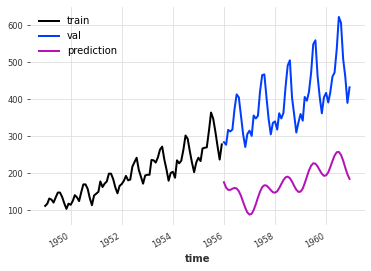

In [13]:
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")

This problem can be solved by setting the optional trend argument to either 'poly' or 'exp', which fits a polynomial or exponential funtion to the data and subtracts it before moving on to DFT. When predicting, the trend is added again.

In [14]:
model = FFT(trend="poly")
model.fit(train)
pred_val = model.predict(len(val))

We have a much better prediction now.

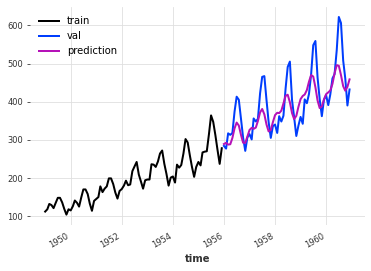

In [15]:
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")

## New Data: Hourly Nuclear Energy Generation

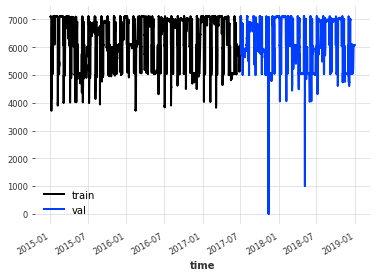

In [16]:
ts_3 = EnergyDataset().load()
ts_3 = fill_missing_values(ts_3, "auto")
ts_3 = ts_3["generation nuclear"]
train, val = ts_3.split_after(pd.Timestamp("2017-07-01"))
train.plot(label="train")
val.plot(label="val")

Instead of simply looking at the performance of the FFT model, we can also look at how a bunch of other forecasting models performs on this new data set in terms of MAE. Surprisingly, on this dataset, the FFT model outperforms all of the others (at least with their default parameters). Granted, this dataset was specifically chosen because of its highly seasonal nature. However, this shows us that there are use cases for FFT. Furthermore, the FFT model has a much shorter running time than the other models!

In [17]:
models = [ExponentialSmoothing(), Theta(), FFT()]

for model in models:
    model.fit(train)
    pred_val = model.predict(len(val))
    print(str(model) + " MAE: " + str(mae(pred_val, val)))

Prophet MAE: 653.8682864837639
Exponential smoothing MAE: 1667.805755244887
Theta(2) MAE: 944.0038491197353
FFT(nr_freqs_to_keep=10, trend=None) MAE: 643.337489093281
